## Question 4

Objective: Demonstrate understanding of how to implement and backtest a trading strategy.

- Backtest either: RSI or MACD strategies.
- Show PnL, annualised sharpe ratio, and drawdown over time.
- Make your code as effieicent (vectorized) as possible.


In [1]:
# Import Python packages
import math
import os
import random
import re
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statistics
from scipy import stats
from itertools import islice
import seaborn as sns

Read in backtest data from the csv file

In [2]:
data_file = "../data/MarketData.csv"
try:
    # Read in data set from the csv file, skip initial metadata rows (first 3 rows)
    f = open(data_file, 'rb')
    df = pd.read_csv(f, skiprows = 3, header = [0, 1, 2, 3])

    # Drop the first column name from the multi-index (for "Dates" column)
    df.columns = ['Dates'] + [f"{col[0]} ({col[1]})" for col in df.columns[1:]]

    # Convert "Dates" column to datetime format, European date format
    df["Dates"] = pd.to_datetime(df["Dates"], dayfirst=True)
    
except:
    print('Error opening file/loading data')

# Display the first few rows
df

,Dates,LME COPPER 3MO ($) (LMCADS03 Comdty),LME ALUMINUM 3MO ($) (LMAHDS03 Comdty),LME ZINC 3MO ($) (LMZSDS03 Comdty),LME LEAD 3MO ($) (LMPBDS03 Comdty),LME TIN 3MO ($) (LMSNDS03 Comdty),Generic 1st 'CL' Future (CL1 Comdty)
0,2010-01-01,7375.0,2230.0,2560.0,2432.0,16950,79.36
1,2010-01-04,7500.0,2267.0,2574.0,2515.0,17450,81.51
2,2010-01-05,7485.0,2302.0,2575.0,2522.5,17375,81.77
3,2010-01-06,7660.0,2377.0,2718.0,2680.0,17825,83.18
4,2010-01-07,7535.0,2310.0,2607.0,2599.0,17475,82.66
...,...,...,...,...,...,...,...
3386,2022-12-26,8349.5,2389.5,2965.0,2273.5,23934,79.56
3387,2022-12-27,8349.5,2389.5,2965.0,2273.5,23934,79.53
3388,2022-12-28,8443.0,2381.0,3005.5,2218.0,24734,78.96
3389,2022-12-29,8418.0,2405.0,2984.5,2272.5,24915,78.40


In [3]:
# Match column names to simple commodity names and colours
commodity_mapping = {
    'LME COPPER    3MO ($) (LMCADS03 Comdty)': ('Copper', 'orange'),
    'LME ALUMINUM  3MO ($) (LMAHDS03 Comdty)': ('Aluminum', 'blue'),
    'LME ZINC      3MO ($) (LMZSDS03 Comdty)': ('Zinc', 'green'),
    'LME LEAD      3MO ($) (LMPBDS03 Comdty)': ('Lead', 'red'),
    'LME TIN       3MO ($) (LMSNDS03 Comdty)': ('Tin', 'purple'),
    'Generic 1st \'CL\' Future (CL1 Comdty)': ('Crude Oil', 'brown')
}
commodity_mapping

{'LME COPPER    3MO ($) (LMCADS03 Comdty)': ('Copper', 'orange'),
 'LME ALUMINUM  3MO ($) (LMAHDS03 Comdty)': ('Aluminum', 'blue'),
 'LME ZINC      3MO ($) (LMZSDS03 Comdty)': ('Zinc', 'green'),
 'LME LEAD      3MO ($) (LMPBDS03 Comdty)': ('Lead', 'red'),
 'LME TIN       3MO ($) (LMSNDS03 Comdty)': ('Tin', 'purple'),
 "Generic 1st 'CL' Future (CL1 Comdty)": ('Crude Oil', 'brown')}

Split data set between "training" (2010-2019) and "testing" (2020-2022) for the backtest

In [4]:
df_train = df[df['Dates'].dt.year.isin(range(2010, 2020))]
df_train

,Dates,LME COPPER 3MO ($) (LMCADS03 Comdty),LME ALUMINUM 3MO ($) (LMAHDS03 Comdty),LME ZINC 3MO ($) (LMZSDS03 Comdty),LME LEAD 3MO ($) (LMPBDS03 Comdty),LME TIN 3MO ($) (LMSNDS03 Comdty),Generic 1st 'CL' Future (CL1 Comdty)
0,2010-01-01,7375.0,2230.0,2560.0,2432.0,16950,79.36
1,2010-01-04,7500.0,2267.0,2574.0,2515.0,17450,81.51
2,2010-01-05,7485.0,2302.0,2575.0,2522.5,17375,81.77
3,2010-01-06,7660.0,2377.0,2718.0,2680.0,17825,83.18
4,2010-01-07,7535.0,2310.0,2607.0,2599.0,17475,82.66
...,...,...,...,...,...,...,...
2603,2019-12-25,6215.0,1814.0,2274.0,1947.0,17125,61.11
2604,2019-12-26,6215.0,1814.0,2274.0,1947.0,17125,61.68
2605,2019-12-27,6214.0,1825.0,2305.0,1939.0,17120,61.72
2606,2019-12-30,6219.0,1827.0,2306.0,1942.0,17000,61.68


In [5]:
df_test = df[df['Dates'].dt.year.isin(range(2020, 2023))]
df_test

,Dates,LME COPPER 3MO ($) (LMCADS03 Comdty),LME ALUMINUM 3MO ($) (LMAHDS03 Comdty),LME ZINC 3MO ($) (LMZSDS03 Comdty),LME LEAD 3MO ($) (LMPBDS03 Comdty),LME TIN 3MO ($) (LMSNDS03 Comdty),Generic 1st 'CL' Future (CL1 Comdty)
2608,2020-01-01,6174.0,1810.0,2272.0,1927.0,17175,61.06
2609,2020-01-02,6188.0,1804.5,2310.0,1919.0,17190,61.18
2610,2020-01-03,6129.5,1824.0,2306.0,1919.0,16800,63.05
2611,2020-01-06,6138.5,1833.0,2324.5,1920.0,16850,63.27
2612,2020-01-07,6149.0,1816.0,2346.0,1906.0,17005,62.70
...,...,...,...,...,...,...,...
3386,2022-12-26,8349.5,2389.5,2965.0,2273.5,23934,79.56
3387,2022-12-27,8349.5,2389.5,2965.0,2273.5,23934,79.53
3388,2022-12-28,8443.0,2381.0,3005.5,2218.0,24734,78.96
3389,2022-12-29,8418.0,2405.0,2984.5,2272.5,24915,78.40


In [6]:
df.set_index('Dates', inplace=True)

Calculate MACD and RSI lines for the whole dataset as in Question 3

In [7]:
def macd(df, fast_window=12, slow_window=26, signal_window=9):

    df_fast_ema = df.ewm(span=fast_window, adjust=False).mean()  # Fast EMA (e.g. 12)
    df_slow_ema = df.ewm(span=slow_window, adjust=False).mean()  # Slow EMA (e.g. 26)
    df_macd_line = df_fast_ema - df_slow_ema  # MACD line (Fast - Slow)
    df_signal_line = df_macd_line.ewm(span=signal_window, adjust=False).mean()  # Signal Line (e.g. 9)
    df_macd_histogram = df_macd_line - df_signal_line # MACD Histogram

    return df_macd_line, df_signal_line, df_macd_histogram

In [8]:
def rsi(df, period=14):

    # Step 1 of RSI calculation: use simple moving average (SMA) for the first period
    # Calculate daily price changes
    df_price_change = df.diff()

    # Separate gains and losses
    df_gains = df_price_change.where(df_price_change > 0, 0)
    df_losses = -df_price_change.where(df_price_change < 0, 0)

    # Compute initial average gain/loss (first 14 values using SMA)
    df_avg_gain = df_gains.rolling(window=period, min_periods=period).mean()
    df_avg_loss = df_losses.rolling(window=period, min_periods=period).mean()

    # # Step 2: Calculate the smoothed averages for RSI
    for i in range(period, len(df)):
        df_avg_gain.iloc[i] = ((df_avg_gain.iloc[i - 1] * (period - 1)) + df_gains.iloc[i]) / period
        df_avg_loss.iloc[i] = ((df_avg_loss.iloc[i - 1] * (period - 1)) + df_losses.iloc[i]) / period

    # Calculate RS (Relative Strength)
    df_rs = df_avg_gain / df_avg_loss

    # Calculate RSI using the formula
    df_rsi = 100 - (100 / (1 + df_rs))

    return df_rsi

Before backtesting any strategy, let's calculate the annualized volatility on commodity prices and daily returns (percentage change) which we are going to use int both strategies. 

In [9]:
# Calculate daily returns
df_returns = df.pct_change()

df_returns_train = df_returns[df_returns.index.year.isin(range(2010, 2020))]
df_returns_test = df_returns[df_returns.index.year.isin(range(2020, 2023))]

In [10]:
# Calculate the annualized volatility on the price of all commodities
def calc_annualized_vol(df_returns, trading_days = 252):

    df_vol = df_returns.rolling(window=trading_days, min_periods=20).std() * np.sqrt(trading_days)

    return df_vol

In [11]:
df_vol = calc_annualized_vol(df_returns)

df_vol_train = df_vol[df_vol.index.year.isin(range(2010, 2020))]
df_vol_test = df_vol[df_vol.index.year.isin(range(2020, 2023))]

df_vol

,LME COPPER 3MO ($) (LMCADS03 Comdty),LME ALUMINUM 3MO ($) (LMAHDS03 Comdty),LME ZINC 3MO ($) (LMZSDS03 Comdty),LME LEAD 3MO ($) (LMPBDS03 Comdty),LME TIN 3MO ($) (LMSNDS03 Comdty),Generic 1st 'CL' Future (CL1 Comdty)
Dates,,,,,,
2010-01-01,NaN,NaN,NaN,NaN,NaN,NaN
2010-01-04,NaN,NaN,NaN,NaN,NaN,NaN
2010-01-05,NaN,NaN,NaN,NaN,NaN,NaN
2010-01-06,NaN,NaN,NaN,NaN,NaN,NaN
2010-01-07,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...
2022-12-26,0.244596,0.305906,0.321154,0.266811,0.393008,0.479235
2022-12-27,0.244270,0.305901,0.321126,0.266509,0.392553,0.479176
2022-12-28,0.244408,0.305847,0.321065,0.267636,0.394103,0.479153


Declare functions to calculate the weighted positions, the strategy return and PnL (cumulative return), Sharpe ratio, Sortino ratio, drawdown etc.

In [12]:
def calculate_weight_matrix(df_positions, df_vol):

    df_weight_matrix = df_positions/df_vol

    return df_weight_matrix

In [13]:
def calculate_strategy_returns(df_returns, df_weight_matrix):

    # Shift weight matrix one row down so we can match the position with the corresponding return on the position
    df_weight_matrix = df_weight_matrix.shift(1)

    # Calculate the daily returns for each position
    df_strategy_returns = df_weight_matrix * df_returns

    return df_strategy_returns


In [14]:
def calculate_cumulative_returns(df_strategy_returns):

    # Sum all asset returns per row to create a single return column
    df_summed_returns = df_strategy_returns.sum(axis=1).to_frame(name="Strategy Returns")

    # Compute cumulative returns
    df_cumulative_returns = (1 + df_summed_returns).cumprod() - 1
    df_cumulative_returns = df_cumulative_returns.rename(columns={"Strategy Returns": "Cumulative Returns"})

    return df_cumulative_returns, df_summed_returns

In [15]:
def plot_cumulative_returns(df_cumulative_returns, strategy = ''):

    plt.figure(figsize=(10, 5))
    plt.plot(df_cumulative_returns.index, df_cumulative_returns["Cumulative Returns"], label="Cumulative Returns")
    plt.xlabel("Date")
    plt.ylabel("Cumulative Return")
    plt.title("Cumulative Returns Over Time - "+strategy+" strategy")
    plt.legend()
    plt.grid(True)
    plt.savefig('cumulative_returns_'+strategy+'.pdf')
    plt.show()

In [16]:
def plot_strategy_returns(df_strategy_returns, strategy = ''):

    plt.figure(figsize=(10, 5))
    plt.plot(df_strategy_returns.index, df_strategy_returns["Strategy Returns"], label="Strategy Returns")
    plt.xlabel("Date")
    plt.ylabel("Strategy Return")
    plt.title("Strategy Returns Over Time - "+strategy+" strategy")
    plt.legend()
    plt.grid(True)
    plt.savefig('strategy_returns_'+strategy+'.pdf')
    plt.show()

In [17]:
def calculate_sharpe_ratio(df_summed_returns, trading_days=252):

    # Calculate the annualized Sharpe ratio assuming 0 risk-free rate
    sharpe_ratio = (df_summed_returns.mean() / df_summed_returns.std()) * np.sqrt(trading_days)

    return sharpe_ratio

In [18]:
def calculate_sortino_ratio(df_summed_returns, trading_days=252):

    # Calculate the annualized Sortino ratio assuming 0 risk-free rate, first selecting the downside returns
    downside_returns = df_summed_returns[df_summed_returns < 0] 
    downside_std = downside_returns.std()

    if downside_std == 0:
        sortino_ratio = np.inf
    else:
        sortino_ratio = (downside_returns.mean() / downside_std) * np.sqrt(trading_days)

    return sortino_ratio

In [19]:
def plot_sharpe_strategy(signal_period, sharpe, strategy=(8, 15)):

    # Plot strategy number against Sharpe ratio in a scatter plot
    plt.figure(figsize=(10, 5))
    plt.scatter(signal_period, sharpe)
    plt.xlabel("Signal window")
    plt.ylabel("Sharpe Ratio")
    plt.title("Sharpe Ratio vs strategy "+str(strategy))
    plt.grid(True)
    plt.show()

In [20]:
def plot_sharpe_heatmap(df_sharpe, signal_window=9):

    # Pivot to a format suitable for heatmap
    heatmap_data = df_sharpe.pivot(index="Fast", columns="Slow", values="Sharpe Ratio")

    # Plot heatmap
    plt.figure(figsize=(10, 6))
    sns.heatmap(heatmap_data, annot=True, fmt=".3f", cmap="coolwarm", linewidths=0.5)
    plt.title("Heatmap of Sharpe Ratio by Fast and Slow MACD windows, signal window = "+str(signal_window))
    plt.xlabel("Slow")
    plt.ylabel("Fast")
    plt.tight_layout()
    #plt.savefig('sharpe_heatmap_signal_'+str(signal_window)+'.pdf')
    plt.show()

In [21]:
def calculate_drawdown(df_cumulative_returns):

    # Track running maximum (peak)
    df_cummulative_max = df_cumulative_returns.cummax()
    
    # Calculate drawdown
    df_drawdown = (df_cumulative_returns - df_cummulative_max) / df_cummulative_max 
    df_drawdown = df_drawdown.rename(columns={"Cumulative Returns": "Drawdown"})
    
    return df_drawdown

In [22]:
def plot_drawdown(df_drawdown, strategy = ''):

    plt.figure(figsize=(10, 5))
    plt.plot(df_drawdown.index, df_drawdown["Drawdown"], label="Drawdown")
    plt.xlabel("Date")
    plt.ylabel("Drawdown")
    plt.title("Drawdowns Over Time - "+strategy+" strategy")
    plt.legend()
    plt.grid(True)
    plt.savefig('drawdown_'+strategy+'.pdf')
    plt.show()

# MACD trading startegy: 1) implement a backtest for the MACD 0-cross strategy
Buy when Signal Line crosses above 0 and sell when it crosses below 0.

In [23]:
def macd_positions(df_signal_line):

    df_macd_positions = pd.DataFrame(np.nan, index=df_signal_line.index, columns=df_signal_line.columns)

    # Vectorized condition for buys (signal line > 0 and not NaN)
    buy_signals = (df_signal_line > 0) & df_signal_line.notna() 

    # Vectorized condition for sells (signal line < 0 and not NaN)
    sell_signals = (df_signal_line < 0) & df_signal_line.notna()

    # Apply trading logic
    df_macd_positions[buy_signals] = 1  # Buy
    df_macd_positions[sell_signals] = 0  # Sell

    return df_macd_positions

In [24]:
# Define a function using slightly different python syntax to trade on the 0-cross line (for debugging purposes)
def macd_positions_revised(df_signal_line):

    df_macd_positions = pd.DataFrame(np.nan, index=df_signal_line.index, columns=df_signal_line.columns)

    df_macd_positions = np.where(df_signal_line > 0, 1, 0)
    print(df_macd_positions)

    return df_macd_positions

Define the logic for the 0-cross trading strategy: <br /> - first we define our signal positions (buy or sell) <br /> - originally we wanted to weight each position by the rolling annualized volatility but the strategy gave rather poor results, therefore we commented out that step <br /> - then the daily returns of the strategy are calculated. We shift each row of the (weighted) position matrix one row down, so we match the market returns data with the corresponding positions. Then we sum up for each day the individual returns of each commodity to get the overall return of the portfolio <br /> - then we calculate the cumulative returns (PnL) of the portfolio <br /> - we also calculate the annualized Sharpe ratio of the portfolio   

In [25]:
def backtest_macd_0cross(df_returns, df_signal_line, df_vol):

    df_macd_positions = macd_positions(df_signal_line)
    #df_weight_matrix = calculate_weight_matrix(df_macd_positions, df_vol)
    df_weight_matrix = df_macd_positions
    df_strategy_returns = calculate_strategy_returns(df_returns, df_weight_matrix)
    df_cumulative_returns, df_summed_returns = calculate_cumulative_returns(df_strategy_returns)
    sharpe_ratio = calculate_sharpe_ratio(df_summed_returns.to_numpy())

    return df_strategy_returns, df_cumulative_returns, df_summed_returns, df_weight_matrix, sharpe_ratio


Let's do a parameter grid search on the parameters of the MACD line and the signal line. First we calculate the MACD and signal lines. Then we split the signal line in training (2010-2019) and testing (2020-2022) datasets and run the MACD 0-crossover strategy on the test dataset with the different parameters. Then we plot the 2D heatmaps of the fast and slow EMA window of the MACD line vs a fixed signal window, the colour of the 2D heatmap is the calculated Sharpe ratio. We'll pick the parameters where the Sharpe ratio consistently shows the highest value for the signal, fast and slow window combination. We also plot in a scatter plot the Sharpe ratios against varying signal line window while keeping the fast-slow EMA window fixed.

In [26]:
# Define grid of various periods considered for MACD:
fast_period_grid = [8, 9, 10, 12, 14, 20, 30]
slow_period_grid = [15, 20, 24, 26, 30, 40, 50]
signal_period_grid = [5, 6, 7, 8, 9, 10, 12]
sharpe = []

for signal_window in signal_period_grid:
    for fast_window in fast_period_grid:
        for slow_window in slow_period_grid:

            if fast_window < slow_window:


                df_macd_line, df_signal_line, df_macd_histogram = macd(df, fast_window, slow_window, signal_window)

                # Split MACD dataframes by train and test
                # df_macd_line_train = df_macd_line[df_macd_line.index.year.isin(range(2010, 2020))]
                # df_macd_line_test = df_macd_line[df_macd_line.index.year.isin(range(2020, 2023))]

                df_signal_line_train = df_signal_line[df_signal_line.index.year.isin(range(2010, 2020))]
                df_signal_line_test = df_signal_line[df_signal_line.index.year.isin(range(2020, 2023))]

                # df_macd_histogram_train = df_macd_histogram[df_macd_hitogram.index.year.isin(range(2010, 2020))]
                # df_macd_histogram_test = df_macd_histogram[df_macd_histogram.index.year.isin(range(2020, 2023))]

                df_strategy_returns, df_cumulative_returns, df_summed_returns, df_weight_matrix, sharpe_ratio = backtest_macd_0cross(df_returns_train, df_signal_line_train, df_vol_train)

                sharpe.append((signal_window, fast_window, slow_window, sharpe_ratio))



In [27]:
sharpe

[(5, 8, 15, -0.024744016525393535),
 (5, 8, 20, -0.027666108080611273),
 (5, 8, 24, -0.03416963833905832),
 (5, 8, 26, -0.04796702015168253),
 (5, 8, 30, -0.161256826347227),
 (5, 8, 40, -0.2217568149097628),
 (5, 8, 50, -0.19361204815730143),
 (5, 9, 15, -0.04977533407198331),
 (5, 9, 20, -0.027400018797923156),
 (5, 9, 24, -0.059179703219735896),
 (5, 9, 26, -0.10535967642986042),
 (5, 9, 30, -0.15529080469333506),
 (5, 9, 40, -0.23685787982217724),
 (5, 9, 50, -0.17930595926837684),
 (5, 10, 15, -0.0644851436855641),
 (5, 10, 20, -0.031302813076437695),
 (5, 10, 24, -0.10799965535391243),
 (5, 10, 26, -0.13698986226182422),
 (5, 10, 30, -0.18740831712560388),
 (5, 10, 40, -0.2691318317756997),
 (5, 10, 50, -0.15052733012340003),
 (5, 12, 15, -0.03260543558533856),
 (5, 12, 20, -0.09155979450725145),
 (5, 12, 24, -0.15283092714210805),
 (5, 12, 26, -0.18300239455155448),
 (5, 12, 30, -0.25139746482087477),
 (5, 12, 40, -0.21114958208705067),
 (5, 12, 50, -0.21368371045488846),
 (5, 1

In [28]:
df_sharpe = pd.DataFrame(sharpe, columns=["Signal", "Fast", "Slow", "Sharpe Ratio"])

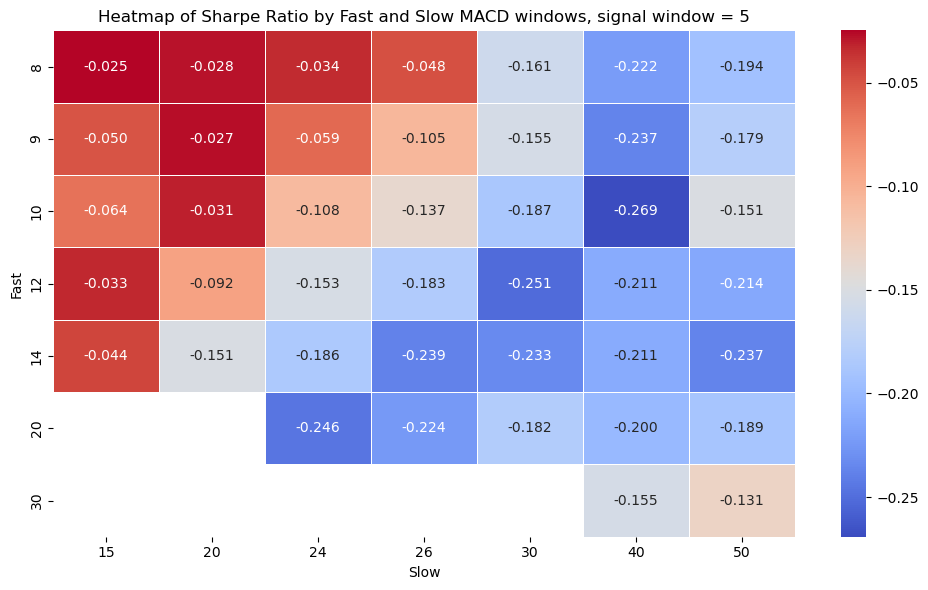

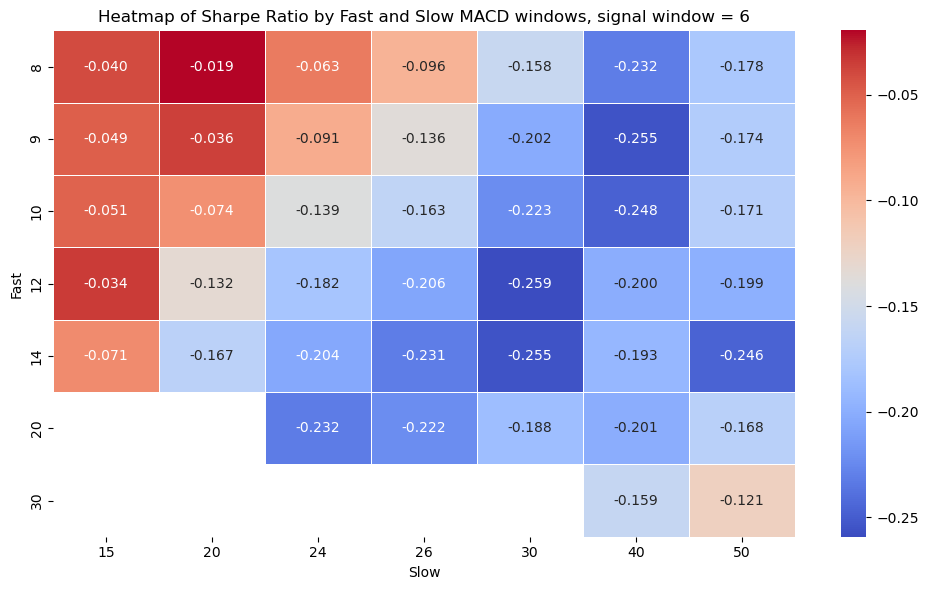

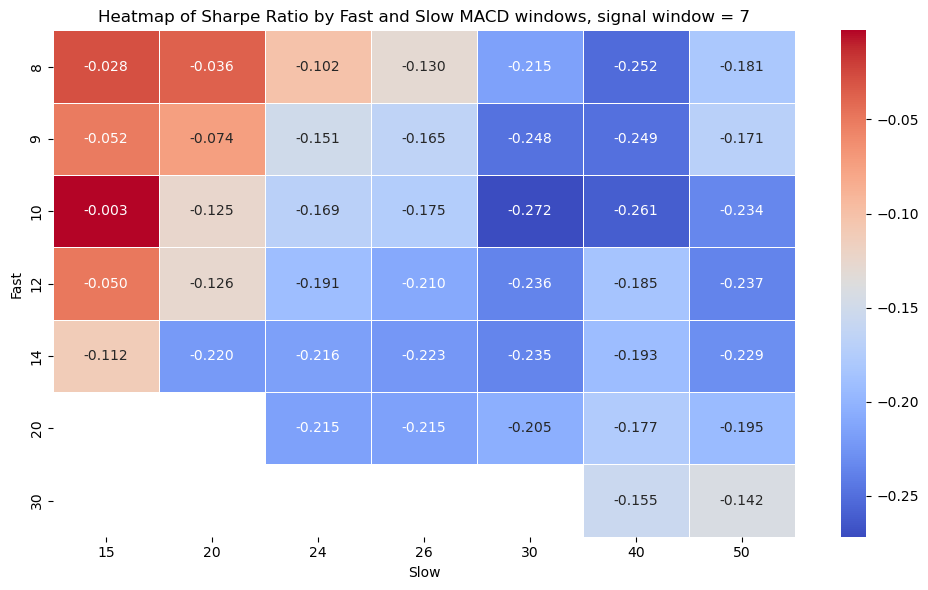

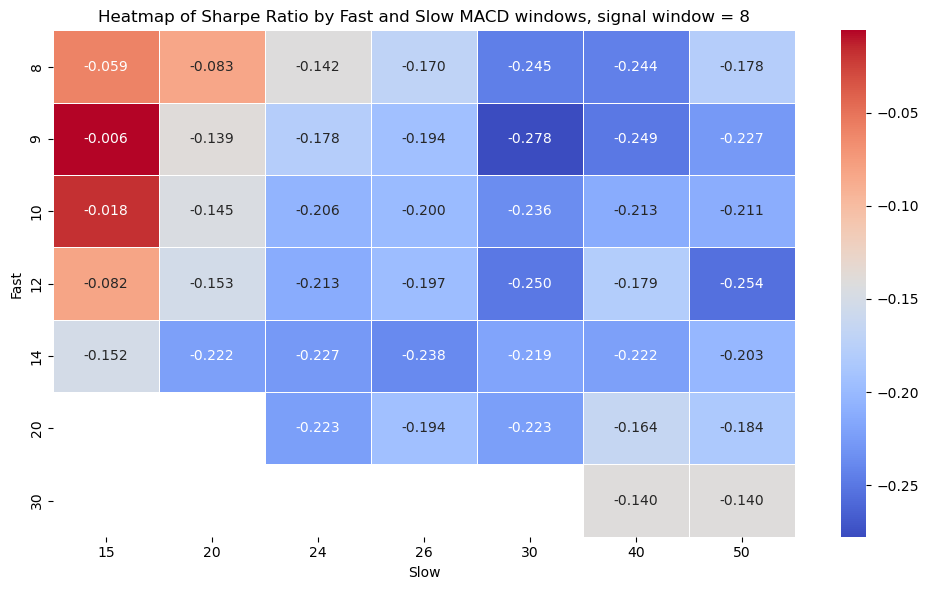

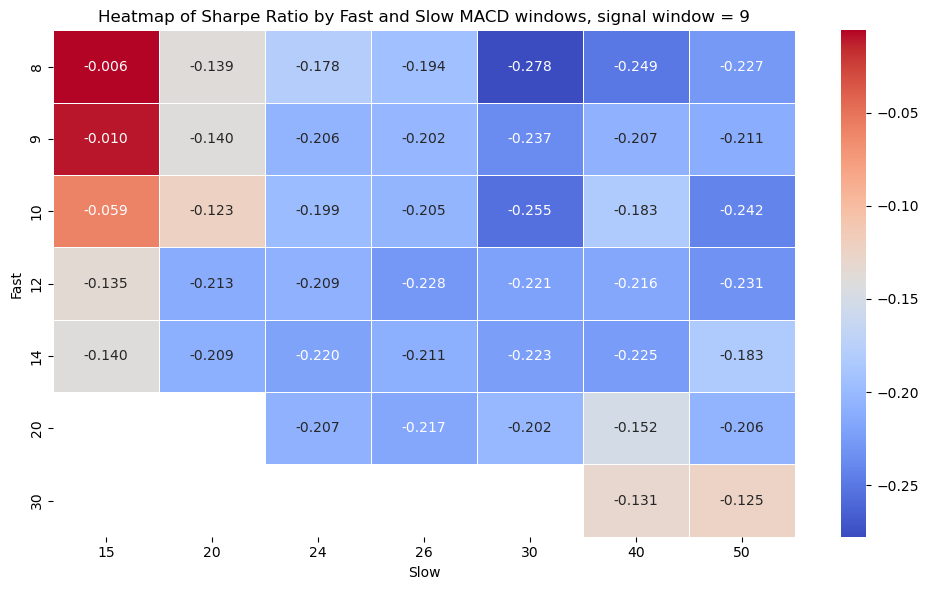

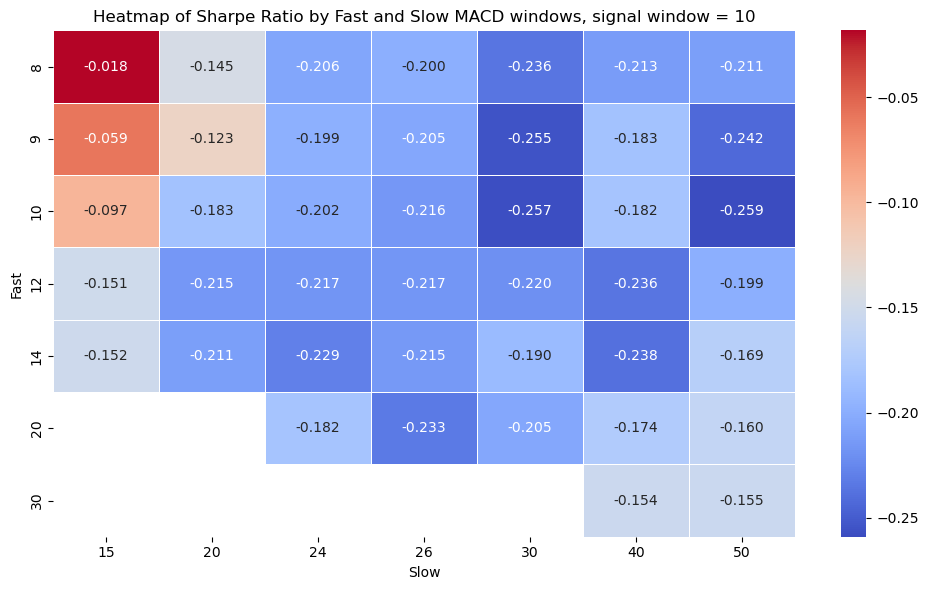

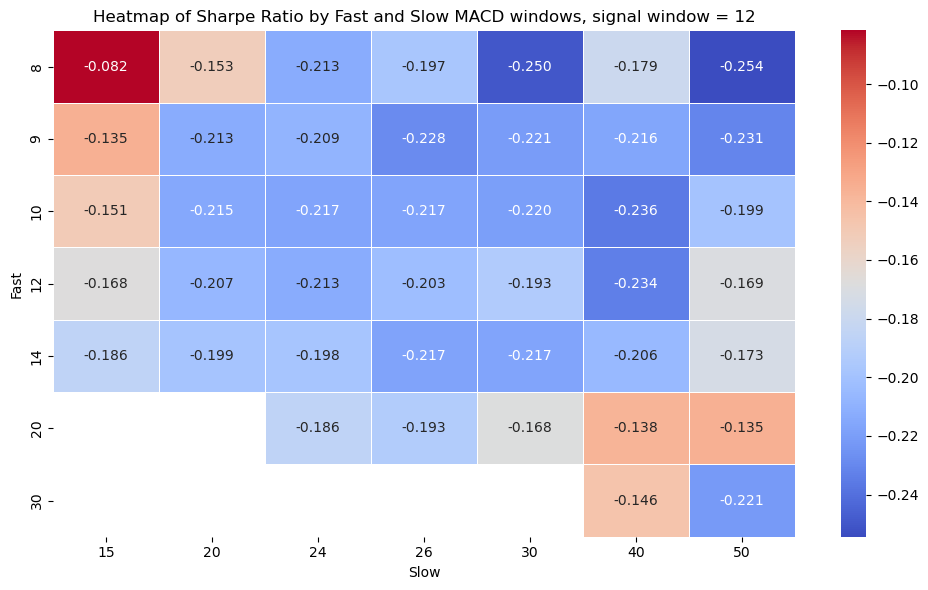

In [29]:
for signal_window in signal_period_grid:

    df_plot = df_sharpe[df_sharpe["Signal"] == signal_window][["Fast", "Slow", "Sharpe Ratio"]].copy()
    plot_sharpe_heatmap(df_plot, signal_window)

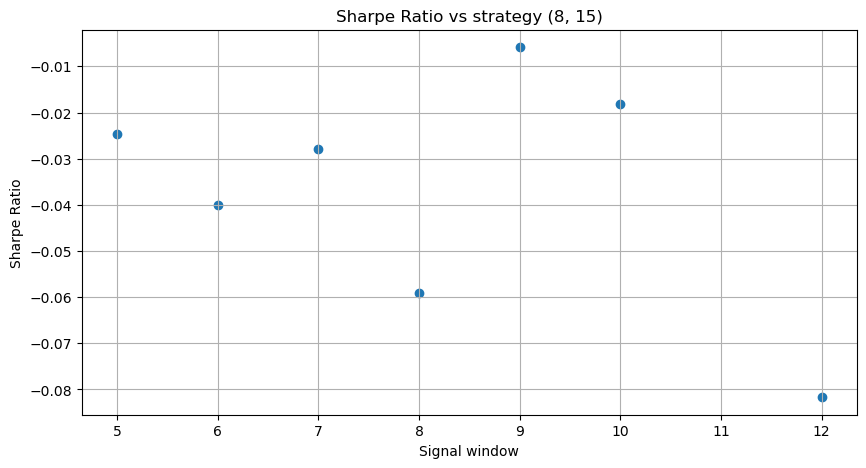

In [30]:
df_plot = df_sharpe[(df_sharpe["Fast"] == 8) & (df_sharpe["Slow"] == 15)][["Sharpe Ratio"]].copy()
plot_sharpe_strategy(signal_period_grid, df_plot["Sharpe Ratio"], strategy=(8, 15))

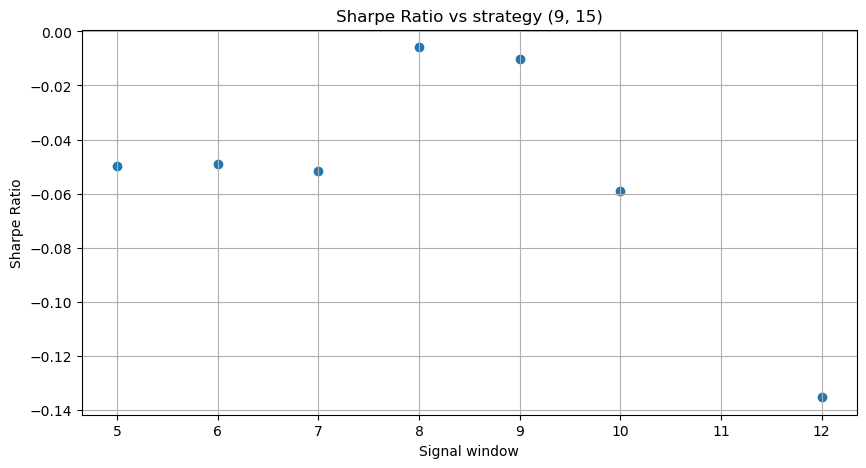

In [31]:
df_plot = df_sharpe[(df_sharpe["Fast"] == 9) & (df_sharpe["Slow"] == 15)][["Sharpe Ratio"]].copy()
plot_sharpe_strategy(signal_period_grid, df_plot["Sharpe Ratio"], strategy=(9, 15))

The conclusion is that the 0-crossover strategy has very low returns and consistently loses money (it has a consistently negative Sharpe ratio). Nevertheless, to make our backtesting exercise complete, let's pick the MACD parameters to be signal=9, fast=8, slow=15, as the (fast, slow) = (8, 15) strategy seemed to show a better trend for the Sharpe ratio curve vs constant signal window peaking at (signal, fast, slow) = (9, 8, 15). In the next part we'll look at the daily returns, cumulative return (PnL), drawdown graphs of the train and test datasets.

In [32]:
signal_window = 9
fast_window = 8
slow_window = 15

df_macd_line, df_signal_line, df_macd_histogram = macd(df, fast_window, slow_window, signal_window)

# Split MACD dataframes by train and test
# df_macd_line_train = df_macd_line[df_macd_line.index.year.isin(range(2010, 2020))]
# df_macd_line_test = df_macd_line[df_macd_line.index.year.isin(range(2020, 2023))]

df_signal_line_train = df_signal_line[df_signal_line.index.year.isin(range(2010, 2020))]
df_signal_line_test = df_signal_line[df_signal_line.index.year.isin(range(2020, 2023))]

# df_macd_histogram_train = df_macd_histogram[df_macd_hitogram.index.year.isin(range(2010, 2020))]
# df_macd_histogram_test = df_macd_histogram[df_macd_histogram.index.year.isin(range(2020, 2023))]

df_strategy_returns_train, df_cumulative_returns_train, df_summed_returns_train, df_weight_matrix_train, sharpe_ratio_train = backtest_macd_0cross(df_returns_train, df_signal_line_train, df_vol_train)
df_strategy_returns_test, df_cumulative_returns_test, df_summed_returns_test, df_weight_matrix_test, sharpe_ratio_test = backtest_macd_0cross(df_returns_test, df_signal_line_test, df_vol_test)


In [33]:
sharpe_ratio_train

-0.0058494431072165474

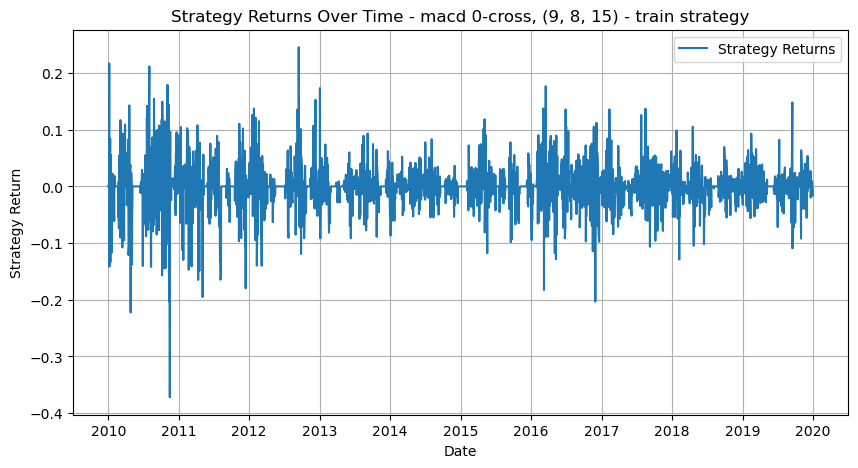

In [34]:
plot_strategy_returns(df_summed_returns_train, 'macd 0-cross, (9, 8, 15) - train')

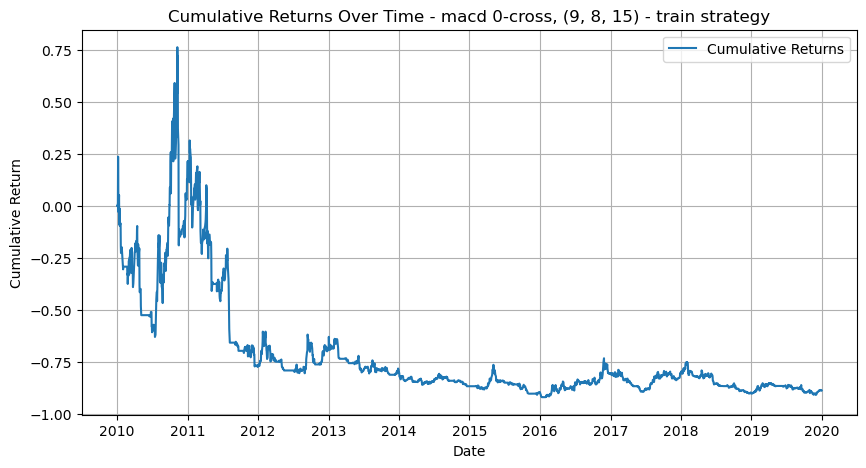

In [35]:
plot_cumulative_returns(df_cumulative_returns_train, 'macd 0-cross, (9, 8, 15) - train')

Calculate drawdown on the train and test datasets of the MACD 0-cross strategy and plot them. 

In [36]:
df_drawdown_train = calculate_drawdown(df_cumulative_returns_train)
df_drawdown_test = calculate_drawdown(df_cumulative_returns_test)

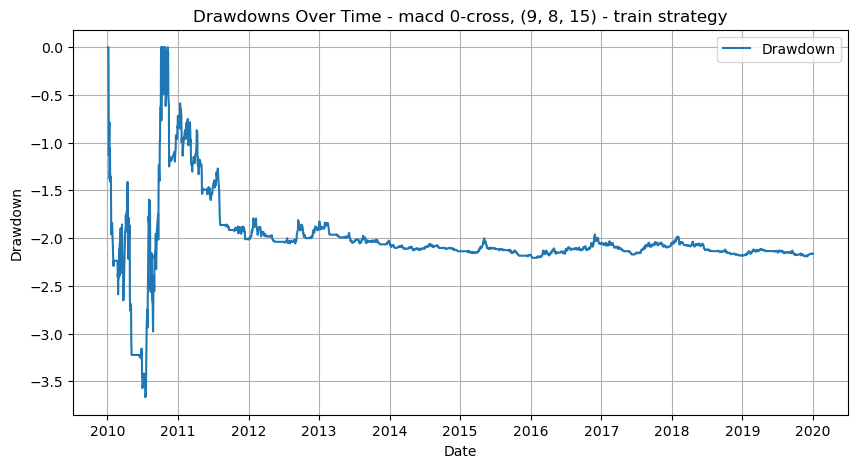

In [37]:
plot_drawdown(df_drawdown_train, 'macd 0-cross, (9, 8, 15) - train')

The train portfolio has prolonged drawdown only able to briefly recover in Q3 of 2010. The strategy proves a consistently poor performance, beyond 2012 becoming stagnant at lows.

Let's see the performance of the MACD 0-cross startegy with the chosen MACD parameters (9, 8, 15) on the test dataset.

In [38]:
sharpe_ratio_test

1.4409590865977266

On the test data set the model returned a Sharpe ratio of 1.44 which is a surprising result, considering it was a losing strategy on the training data set...

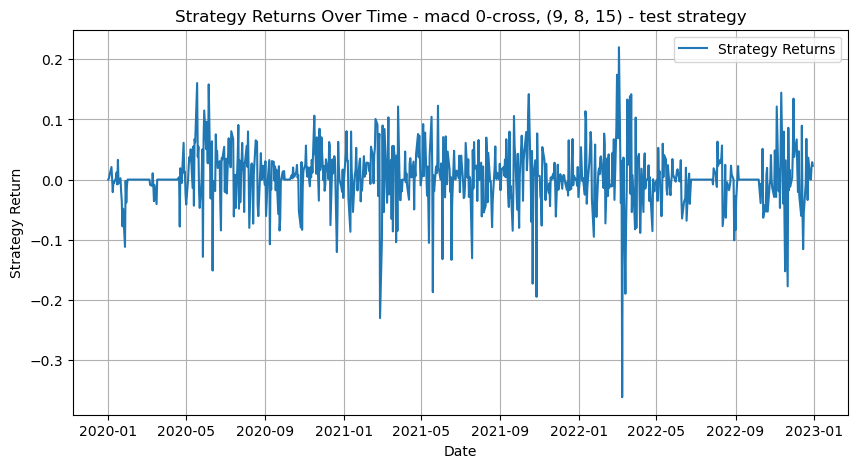

In [39]:
plot_strategy_returns(df_summed_returns_test, 'macd 0-cross, (9, 8, 15) - test')

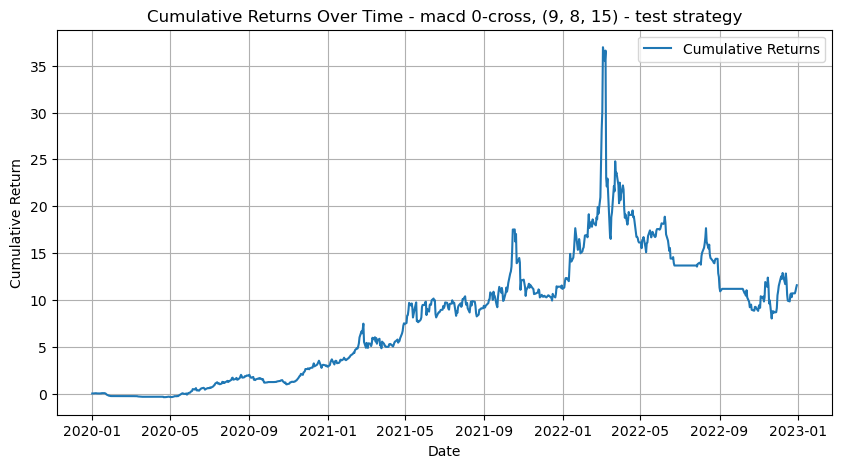

In [40]:
plot_cumulative_returns(df_cumulative_returns_test, 'macd 0-cross, (9, 8, 15) - test')

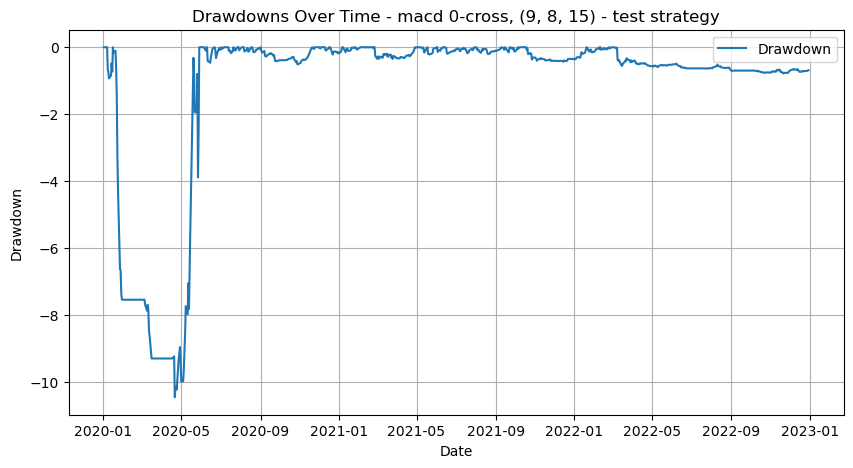

In [41]:
plot_drawdown(df_drawdown_test, 'macd 0-cross, (9, 8, 15) - test')

The MACD 0-cross strategy seems to have positive returns on the test dataset for the chosen MACD parameters. Maybe there is alpha signal in this strategy or we got lucky over the time period we tested the strategy. The drawdown graph also shows shallow drawdowns with relatively fast recovery (few days). The portfolio reaches its maximum in March 2022, then the performance of the strategy deteriorates, eventually losing money (also shown in the drawdown plot). 

# 2) Implement MACD strategy trading on the gap between the MACD line and the signal line
When MACD crosses above the signal line then buy, when it crosses below the signal line then sell

In [43]:
def macd_positions_crossover(df_macd_line, df_signal_line):

    df_macd_positions = pd.DataFrame(np.nan, index=df_signal_line.index, columns=df_signal_line.columns)

    # Vectorized condition for buys (MACD line > signal line > 0, not NaN)
    buy_signals = (df_macd_line > df_signal_line) & df_signal_line.notna() #& (df_macd_line.shift(1) <= df_signal_line.shift(1))

    # Vectorized condition for sells (signal line < 0 and not NaN)
    sell_signals = (df_macd_line < df_signal_line) & df_signal_line.notna() #& (df_macd_line.shift(1) >= df_signal_line.shift(1))

    # Apply trading logic
    df_macd_positions[buy_signals] = 1  # Buy
    df_macd_positions[sell_signals] = 0  # Sell

    return df_macd_positions

Define the logic for the MACD crossover trading strategy: <br /> - first we define our signal positions (buy or sell) <br /> - originally we wanted to weight each position by the rolling annualized volatility but the strategy gave rather poor results, therefore we commented out that step <br /> - then the daily returns of the strategy are calculated. We shift each row of the (weighted) position matrix one row down, so we match the market returns data with the corresponding positions. Then we sum up for each day the individual returns of each commodity to get the overall return of the portfolio <br /> - then we calculate the cumulative returns (PnL) of the portfolio <br /> - we also calculate the annualized Sharpe ratio of the portfolio  

In [44]:
def backtest_macd_crossover(df_returns, df_macd_line, df_signal_line, df_vol):

    df_macd_positions = macd_positions_crossover(df_macd_line, df_signal_line)
    #df_weight_matrix = calculate_weight_matrix(df_macd_positions, df_vol)
    df_weight_matrix = df_macd_positions
    df_strategy_returns = calculate_strategy_returns(df_returns, df_weight_matrix)
    df_cumulative_returns, df_summed_returns = calculate_cumulative_returns(df_strategy_returns)
    sharpe_ratio = calculate_sharpe_ratio(df_summed_returns.to_numpy())

    return df_strategy_returns, df_cumulative_returns, df_summed_returns, df_weight_matrix, sharpe_ratio

In [45]:
# Define grid of various periods considered for MACD:
fast_period_grid = [8, 9, 10, 12, 14, 20, 30]
slow_period_grid = [15, 20, 24, 26, 30, 40, 50]
signal_period_grid = [5, 6, 7, 8, 9, 10, 12]
sharpe = []

for signal_window in signal_period_grid:
    for fast_window in fast_period_grid:
        for slow_window in slow_period_grid:

            if fast_window < slow_window:


                df_macd_line, df_signal_line, df_macd_histogram = macd(df, fast_window, slow_window, signal_window)

                # Split MACD dataframes by train and test
                df_macd_line_train = df_macd_line[df_macd_line.index.year.isin(range(2010, 2020))]
                df_macd_line_test = df_macd_line[df_macd_line.index.year.isin(range(2020, 2023))]

                df_signal_line_train = df_signal_line[df_signal_line.index.year.isin(range(2010, 2020))]
                df_signal_line_test = df_signal_line[df_signal_line.index.year.isin(range(2020, 2023))]

                # df_macd_histogram_train = df_macd_histogram[df_macd_histogram.index.year.isin(range(2010, 2020))]
                # df_macd_histogram_test = df_macd_histogram[df_macd_histogram.index.year.isin(range(2020, 2023))]

                df_strategy_returns, df_cumulative_returns, df_summed_returns, df_weight_matrix, sharpe_ratio = backtest_macd_crossover(df_returns_train, df_macd_line_train, df_signal_line_train, df_vol_train)

                sharpe.append((signal_window, fast_window, slow_window, sharpe_ratio))

In [46]:
sharpe

[(5, 8, 15, 0.1726836625927798),
 (5, 8, 20, 0.14675734677791807),
 (5, 8, 24, 0.1349398426701444),
 (5, 8, 26, 0.1211981942639637),
 (5, 8, 30, 0.15118686805311865),
 (5, 8, 40, 0.20217622259511595),
 (5, 8, 50, 0.13923794429230646),
 (5, 9, 15, 0.17266052609915036),
 (5, 9, 20, 0.14238590229719558),
 (5, 9, 24, 0.16625012391726715),
 (5, 9, 26, 0.15971475628403486),
 (5, 9, 30, 0.18940593227877406),
 (5, 9, 40, 0.16949527767276268),
 (5, 9, 50, 0.10422688956298419),
 (5, 10, 15, 0.19245801055732276),
 (5, 10, 20, 0.16495642760366258),
 (5, 10, 24, 0.14853445039496618),
 (5, 10, 26, 0.16257689708459236),
 (5, 10, 30, 0.21504892361434758),
 (5, 10, 40, 0.11592478965728074),
 (5, 10, 50, 0.074047415159517),
 (5, 12, 15, 0.18753942147551042),
 (5, 12, 20, 0.11983324224005482),
 (5, 12, 24, 0.185557573219287),
 (5, 12, 26, 0.18134960542556705),
 (5, 12, 30, 0.15546732898946383),
 (5, 12, 40, 0.13492076415980694),
 (5, 12, 50, 0.05457583785364469),
 (5, 14, 15, 0.12640950267627737),
 (5, 1

In [47]:
df_sharpe = pd.DataFrame(sharpe, columns=["Signal", "Fast", "Slow", "Sharpe Ratio"])

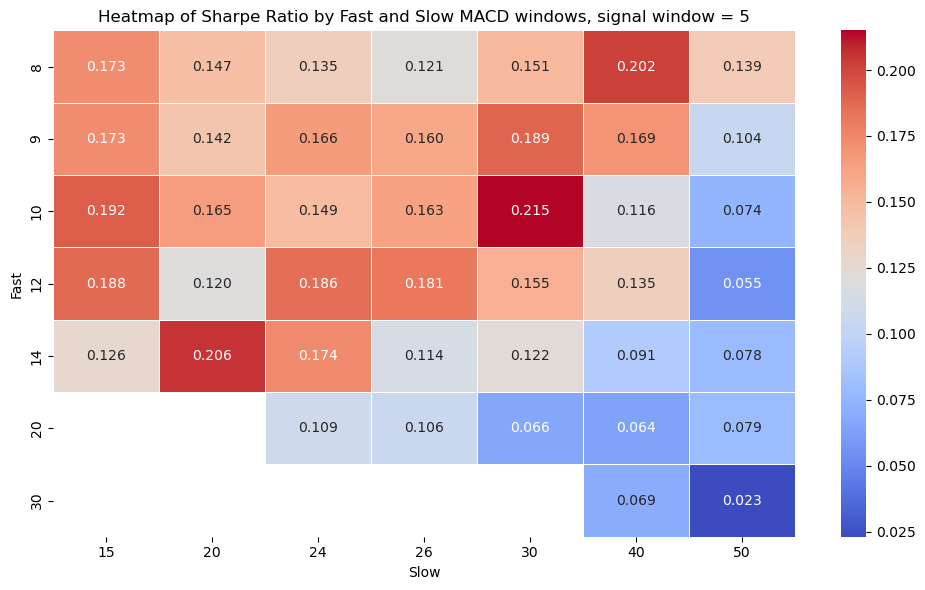

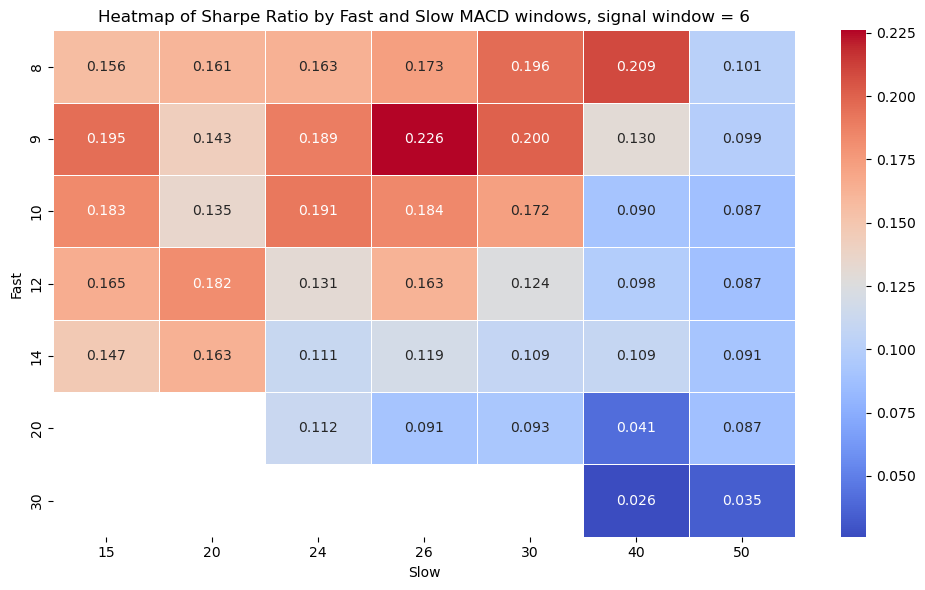

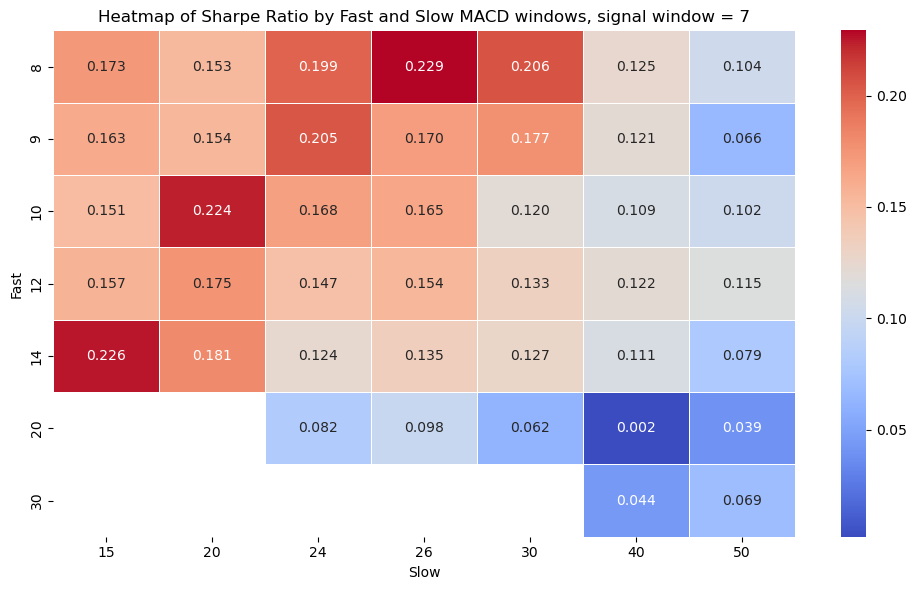

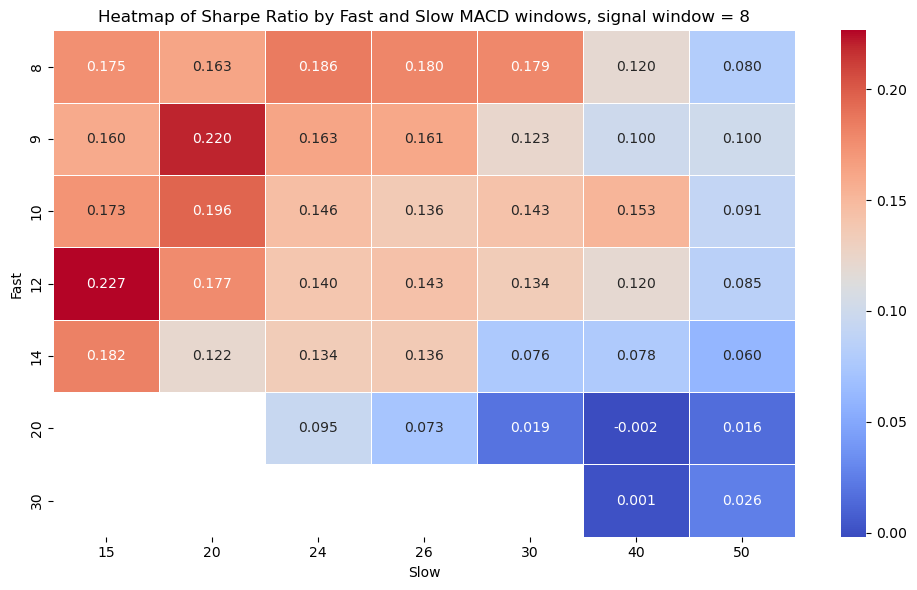

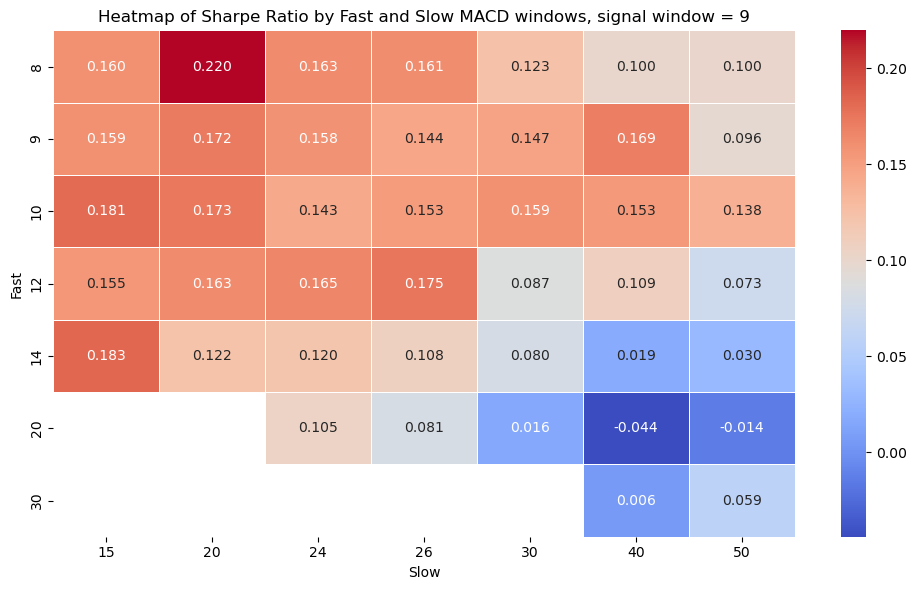

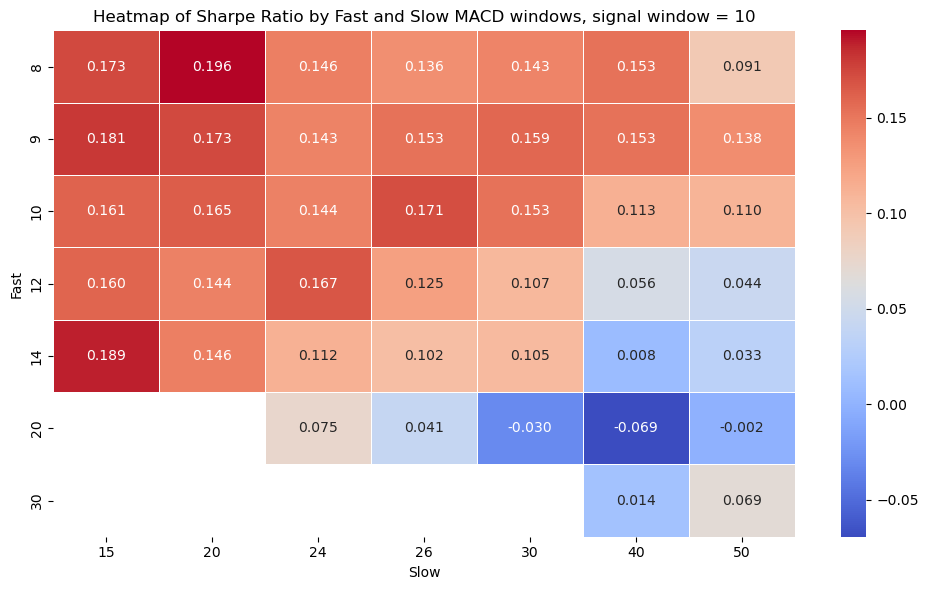

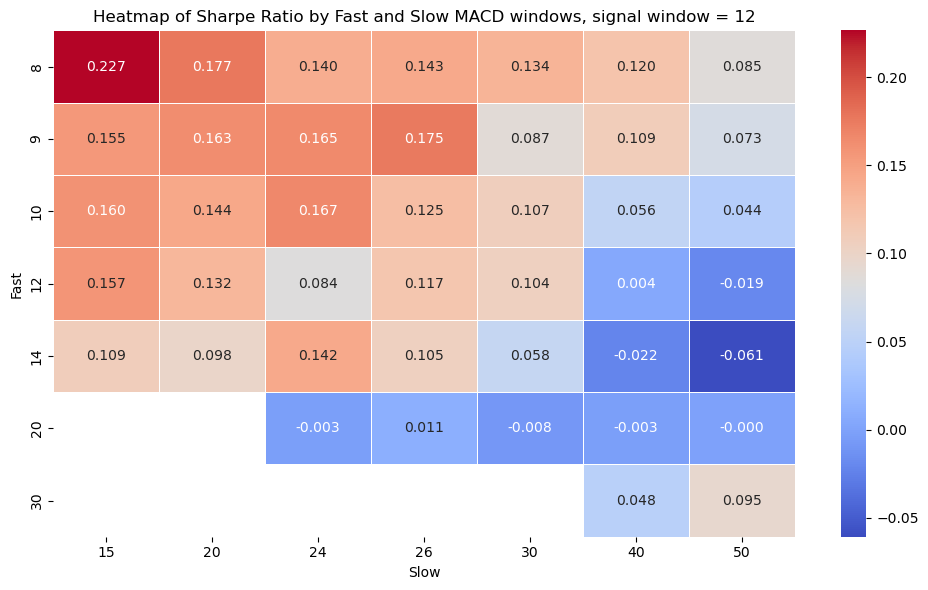

In [48]:
for signal_window in signal_period_grid:

    df_plot = df_sharpe[df_sharpe["Signal"] == signal_window][["Fast", "Slow", "Sharpe Ratio"]].copy()
    plot_sharpe_heatmap(df_plot, signal_window)

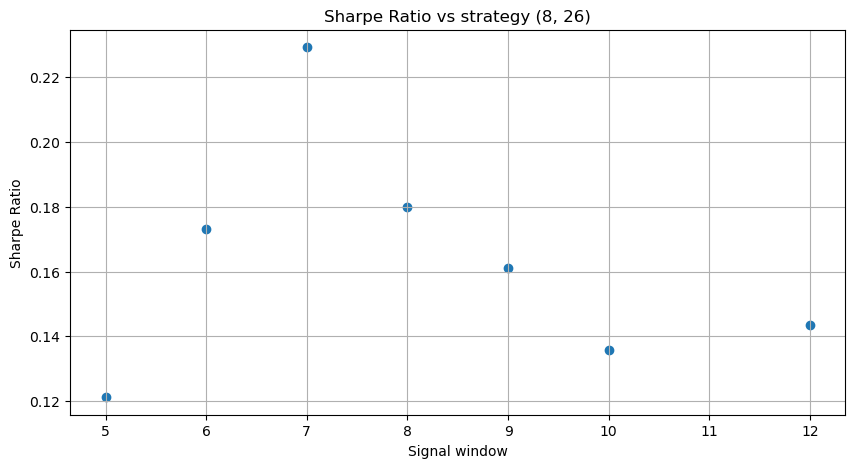

In [49]:
df_plot = df_sharpe[(df_sharpe["Fast"] == 8) & (df_sharpe["Slow"] == 26)][["Sharpe Ratio"]].copy()
plot_sharpe_strategy(signal_period_grid, df_plot["Sharpe Ratio"], strategy=(8, 26))

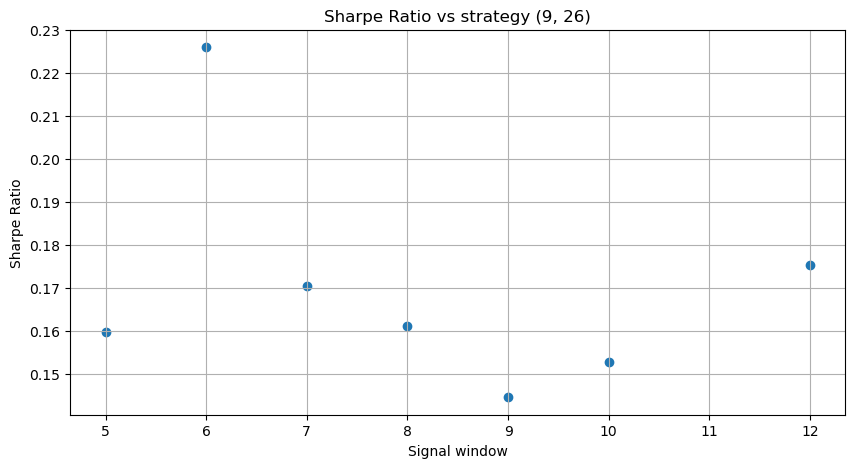

In [50]:
df_plot = df_sharpe[(df_sharpe["Fast"] == 9) & (df_sharpe["Slow"] == 26)][["Sharpe Ratio"]].copy()
plot_sharpe_strategy(signal_period_grid, df_plot["Sharpe Ratio"], strategy=(9, 26))

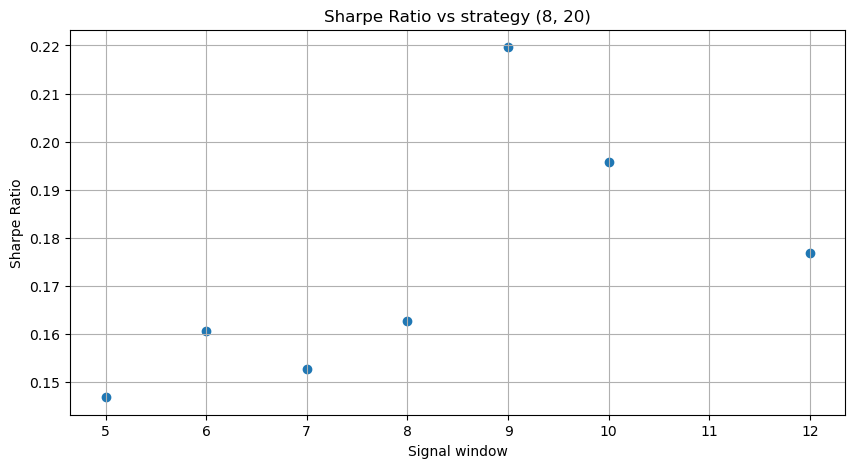

In [51]:
df_plot = df_sharpe[(df_sharpe["Fast"] == 8) & (df_sharpe["Slow"] == 20)][["Sharpe Ratio"]].copy()
plot_sharpe_strategy(signal_period_grid, df_plot["Sharpe Ratio"], strategy=(8, 20))

Based on the output of the grid search on the train dataset, it seems that the crossover method of the MACD and signal lines may have more alpha, as we can systematically get positive Sharpe ratio of a modest performance (around 0.2). The hottest area (highest Sharpe ratio per fixed signal window) is in the top left area of the heatmap as the signal window increases. The scatter plots show similar, damped sine-wave like shapes with different period length as we keep the fast and slow windows fixed and only change the signal line window for the fast-slow window combinations we tested. We decided that a reasonable best parameter combination would be (signal, fast, slow) = (7, 8, 26) with a Sharpe ratios of 0.23 on the train dataset. Now let's look at the returns, cumulative returns, drawdown graphs on both the train and test datasets.

In [52]:
fast_window = 8
slow_window = 26
signal_window = 7

df_macd_line, df_signal_line, df_macd_histogram = macd(df, fast_window, slow_window, signal_window)

# Split MACD dataframes by train and test
df_macd_line_train = df_macd_line[df_macd_line.index.year.isin(range(2010, 2020))]
df_macd_line_test = df_macd_line[df_macd_line.index.year.isin(range(2020, 2023))]

df_signal_line_train = df_signal_line[df_signal_line.index.year.isin(range(2010, 2020))]
df_signal_line_test = df_signal_line[df_signal_line.index.year.isin(range(2020, 2023))]

# df_macd_histogram_train = df_macd_histogram[df_macd_histogram.index.year.isin(range(2010, 2020))]
# df_macd_histogram_test = df_macd_histogram[df_macd_histogram.index.year.isin(range(2020, 2023))]

df_strategy_returns_train, df_cumulative_returns_train, df_summed_returns_train, df_weight_matrix_train, sharpe_ratio_train = backtest_macd_crossover(df_returns_train, df_macd_line_train, df_signal_line_train, df_vol_train)
df_strategy_returns_test, df_cumulative_returns_test, df_summed_returns_test, df_weight_matrix_test, sharpe_ratio_test = backtest_macd_crossover(df_returns_test, df_macd_line_test, df_signal_line_test, df_vol_test)

In [53]:
sharpe_ratio_train

0.2292779569003617

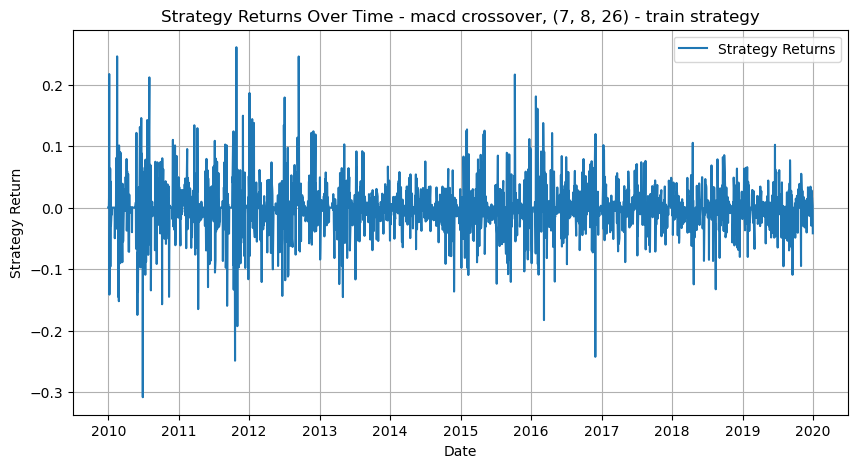

In [54]:
plot_strategy_returns(df_summed_returns_train, 'macd crossover, (7, 8, 26) - train')

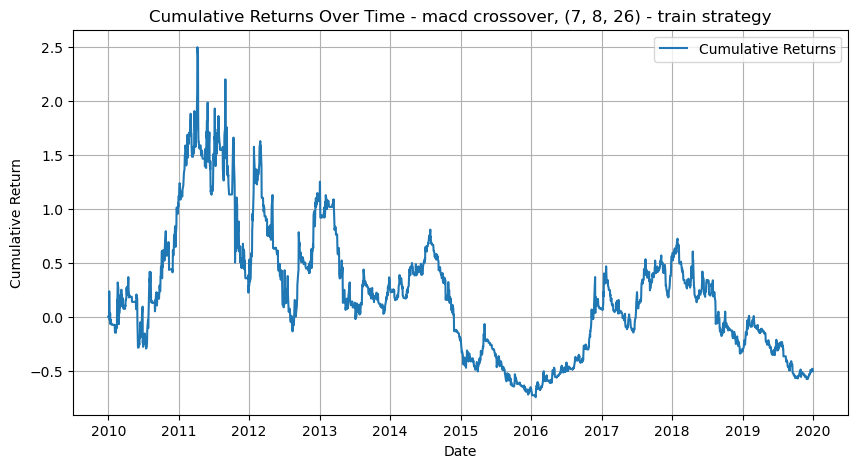

In [55]:
plot_cumulative_returns(df_cumulative_returns_train, 'macd crossover, (7, 8, 26) - train')

In [56]:
df_drawdown_train = calculate_drawdown(df_cumulative_returns_train)
df_drawdown_test = calculate_drawdown(df_cumulative_returns_test)

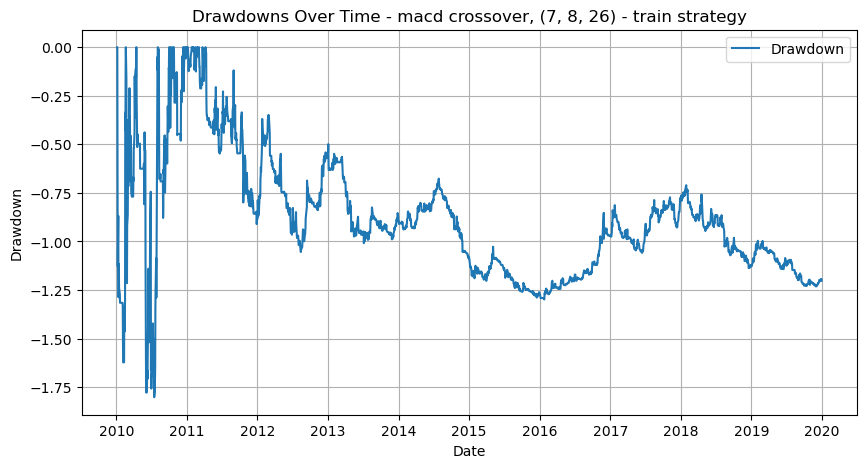

In [57]:
plot_drawdown(df_drawdown_train, 'macd crossover, (7, 8, 26) - train')

The MACD crossover strategy on the chosen parameters shows better returns on the train dataset, compared to the 0-crossover strategy. However, after the initial rising period and high, the performance drops and never recovers to the same peak. Let's see how the strategy performs on the test dataset.

In [58]:
sharpe_ratio_test

-0.24858652984075796

The strategy seems to have lost money on the test dataset, which is surprising considering the consistency in the train dataset. There might not be alpha signal there or we go unlucky...

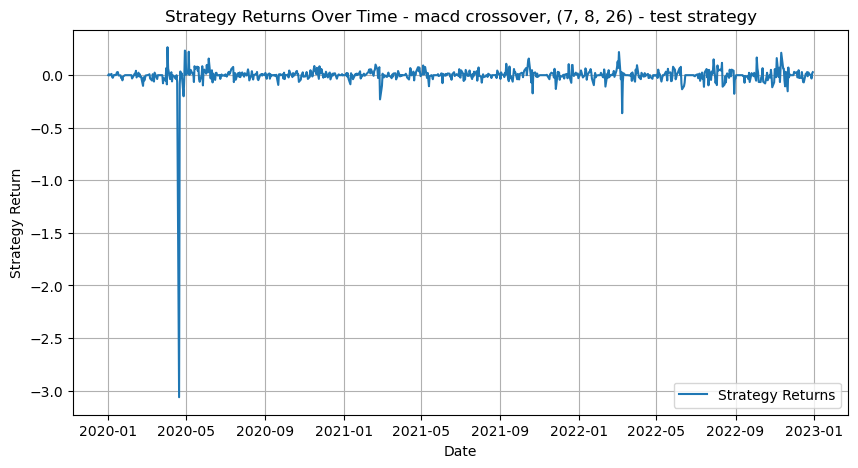

In [59]:
plot_strategy_returns(df_summed_returns_test, 'macd crossover, (7, 8, 26) - test')

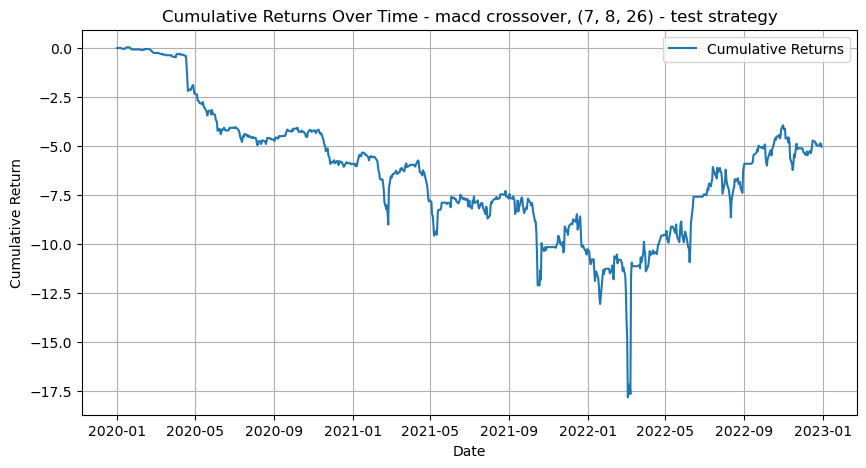

In [60]:
plot_cumulative_returns(df_cumulative_returns_test, 'macd crossover, (7, 8, 26) - test')

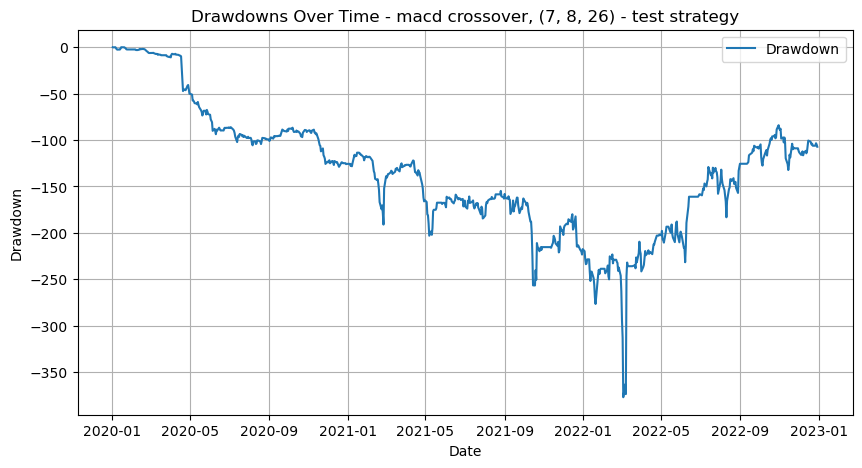

In [61]:
plot_drawdown(df_drawdown_test, 'macd crossover, (7, 8, 26) - test')

The MACD crossover strategy with parameters of (7, 8, 30) has lost money on the test dataset. There was a sharp drawdown in April 2020 (probably due to the start of the Covid-19 pandemic when crude oil price went negative) but that trough quickly recovered. Nevertheless, the strategy has been losing money as the training dataset had different market conditions (pre-Covid pandemic) to when the strategy was tested (Covid-19 pandemic when all asset prices have been significantly impacted, particularly commodities, as the global economy was interrupted due to lockdowns and factories didn't need as many commodities for their closed production lines),   

# RSI Strategy 
Buy when RSI is below oversold line (30) and sell when above overbought line (70) AND you're not already in a position, i.e. "buy low sell high" strategy. Since the buy and sell condition depends on the previous day's position, we need to loop through the daily positions, I could not find a good vectorized method in python to implement the RSI trading strategy... The steps of the backtest are the same as in the previous two strategies.

In [ ]:
def rsi_positions(df_rsi):

    df_rsi_positions = pd.DataFrame(0, index=df_rsi.index, columns=df_rsi.columns)

    # Vectorized condition for buys (RSI < 30 and not NaN)
    buy_signals = (df_rsi < 30) & df_rsi.notna()

    # Vectorized condition for sells (RSI > 70 and not NaN)
    sell_signals = (df_rsi > 70) & df_rsi.notna()

    for i in range(1, len(df_rsi)):
        # df_rsi_positions.iloc[i] = df_rsi_positions.iloc[i - 1]  # Default to previous position
        # df_rsi_positions.loc[i, buy_signals.iloc[i] & (df_rsi_positions.iloc[i - 1] == 0)] = 1 # Apply buy condition
        # df_rsi_positions.loc[i, sell_signals.iloc[i] & (df_rsi_positions.iloc[i - 1] == 1)] = 0  # Apply sell condition

        df_rsi_positions.iloc[i] = df_rsi_positions.iloc[i - 1]  # Default to previous position
        df_rsi_positions.iloc[i][buy_signals.iloc[i] & (df_rsi_positions.iloc[i - 1] == 0)] = 1  # Apply buy condition
        df_rsi_positions.iloc[i][sell_signals.iloc[i] & (df_rsi_positions.iloc[i - 1] == 1)] = 0  # Apply sell condition

    return df_rsi_positions

In [ ]:
def backtest_rsi(df_returns, df_rsi, df_vol):

    df_rsi_positions = rsi_positions(df_rsi)
    #df_weight_matrix = calculate_weight_matrix(df_rsi_positions, df_vol)
    df_weight_matrix = df_rsi_positions
    df_strategy_returns = calculate_strategy_returns(df_returns, df_weight_matrix)
    df_cumulative_returns, df_summed_returns = calculate_cumulative_returns(df_strategy_returns)
    sharpe_ratio = calculate_sharpe_ratio(df_summed_returns.to_numpy())

    return df_strategy_returns, df_cumulative_returns, df_summed_returns, df_weight_matrix, sharpe_ratio

In [ ]:
# Define grid of various periods considered for RSI:
rsi_period_grid = [14, 21, 30, 50]
sharpe = []

for rsi_period in rsi_period_grid:

    df_rsi = rsi(df, rsi_period)

    # Split RSI dataframe by train and test
    df_rsi_train = df_rsi[df_rsi.index.year.isin(range(2010, 2020))]
    df_rsi_test = df_rsi[df_rsi.index.year.isin(range(2020, 2023))]

    df_strategy_returns, df_cumulative_returns, df_summed_returns, df_weight_matrix, sharpe_ratio = backtest_rsi(df_returns_train, df_rsi_train, df_vol_train)

    sharpe.append((rsi_period, sharpe_ratio))

In [ ]:
df_sharpe = pd.DataFrame(sharpe, columns=["RSI Period", "Sharpe Ratio"])
sharpe

In [ ]:
plot_sharpe_strategy(df_sharpe["RSI Period"], df_sharpe["Sharpe Ratio"], strategy="RSI")

It seems that there might be potential alpha signal in the RSI method, with the best RSI period being at 21 days, the model returning a Sharpe ratio of 0.5 (still lower than the typical benchmark of 1).

In [ ]:
rsi_period = 21
df_rsi = rsi(df, rsi_period)

# Split RSI dataframe by train and test
df_rsi_train = df_rsi[df_rsi.index.year.isin(range(2010, 2020))]
df_rsi_test = df_rsi[df_rsi.index.year.isin(range(2020, 2023))]

df_strategy_returns_train, df_cumulative_returns_train, df_summed_returns_train, df_weight_matrix_train, sharpe_ratio_train = backtest_rsi(df_returns_train, df_rsi_train, df_vol_train)
df_strategy_returns_test, df_cumulative_returns_test, df_summed_returns_test, df_weight_matrix_test, sharpe_ratio_test = backtest_rsi(df_returns_test, df_rsi_test, df_vol_test)

df_drawdown_train = calculate_drawdown(df_cumulative_returns_train)
df_drawdown_test = calculate_drawdown(df_cumulative_returns_test)

In [ ]:
plot_strategy_returns(df_summed_returns_train, 'RSI (21) - train')

In [ ]:
plot_cumulative_returns(df_cumulative_returns_train, 'RSI (21) - train')

In [ ]:
plot_drawdown(df_drawdown_train, 'RSI (21) - train')

The strategy shows increasing returns initially but eventually it collapses by the end of 2014 and never fully recovers, it stagnates instead. Nevertheless, it shows positive returns for the train period, yet there might not be real alpha (Sharpe ratio of the train dataset was 0.4 which is below the typical benchmark of 1 considered as a good strategy). Now let's see the strategy's returns on the test dataset.

In [ ]:
sharpe_ratio_test

The RSI (21) strategy seems to have lost money on the test dataset, therefore there wasn't really alpha in it. Again, let's remember that the strategy has been trained on different market conditions (pre-Covid) to what it was applied on (Covid-19 pandemic.)

In [ ]:
plot_strategy_returns(df_summed_returns_test, 'RSI (21) - test')

The daily returns graph shows that the strategy wasn't trading much for more than a year between January 2021 and May 2022, which gives a poor performance and criticism on whether it has real alpha vale. We can also observe the sharp crash at the beginning of the pandemic at the end of March 2020 which we also observed in the MACD crossover strategy.

In [ ]:
plot_cumulative_returns(df_cumulative_returns_test, 'RSI (21) - test')

In [ ]:
plot_drawdown(df_drawdown_test, 'RSI (21) - test')

We observe a large drawdown as the Covid-19 pandemic started but shortly after, the strategy recovered. Nevertheless, the period when no trading happened gives concern over the feasibility of this strategy.

Plot commodity price time series with the MACD lines for (7, 8, 26) and RSI (21) over whole time period for each commodity, showing the split between the training and testing datasets (2020-01-01)

NameError: name 'df_rsi' is not defined

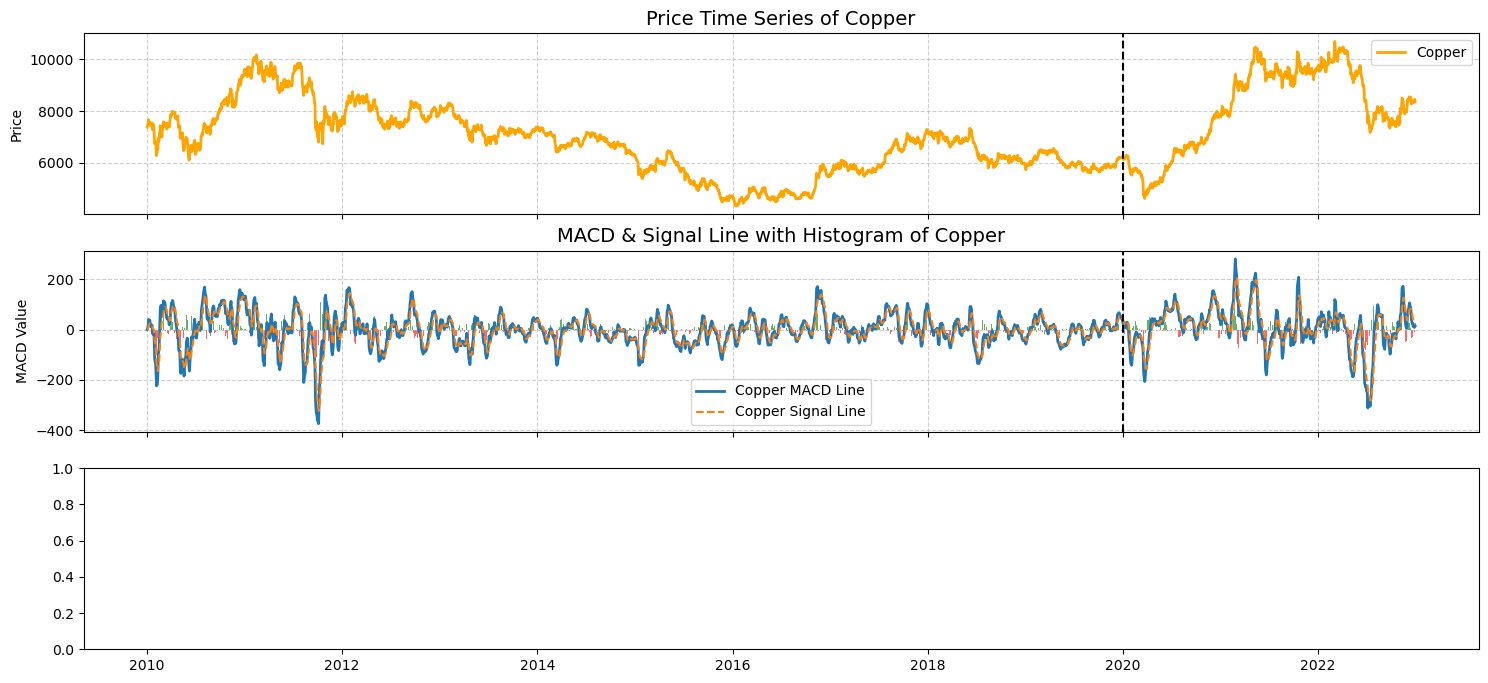

In [42]:
for comdty in commodity_mapping.keys():

    # Create figure and subplots
    fig, ax = plt.subplots(3, 1, figsize=(18, 8), sharex=True, gridspec_kw={'height_ratios': [1, 1, 1]})

    name, colour = commodity_mapping[comdty]

    # --- Price Time Series (Top) ---
    ax[0].plot(df.index, df[comdty], label=name, color=colour, linewidth=2)
    ax[0].set_title('Price Time Series of '+name, fontsize=14)
    ax[0].set_ylabel('Price')
    ax[0].legend()
    # Add vertical dashed line at 01-01-2020 which is the boundary between the training and test dataset
    highlight_date = pd.Timestamp("2020-01-01")
    ax[0].axvline(x=highlight_date, color='black', linestyle='--')
    ax[0].grid(True, linestyle='--', alpha=0.6)

    # --- MACD, Signal & Histogram (Middle) ---
    ax[1].plot(df.index, df_macd_line[comdty], linewidth=2, label=name+' MACD Line')
    ax[1].plot(df.index, df_signal_line[comdty], linewidth=1.5, linestyle='dashed', label=name+' Signal Line')

    # Histogram bars
    ax[1].bar(df.index, df_macd_histogram[comdty], color=['green' if v >= 0 else 'red' for v in df_macd_histogram[comdty]], width=0.8, alpha=0.6)

    ax[1].set_title('MACD & Signal Line with Histogram of '+name, fontsize=14)
    ax[1].set_ylabel('MACD Value')
    ax[1].legend()
    ax[1].axvline(x=highlight_date, color='black', linestyle='--')
    ax[1].grid(True, linestyle='--', alpha=0.6)

    # --- Plot RSI (Bottom) ---
    ax[2].plot(df.index, df_rsi[comdty], linewidth=2, label=name+' RSI')
    ax[2].axhline(70, color='red', linestyle='dashed', linewidth=1, label='Overbought (70)')
    ax[2].axhline(30, color='blue', linestyle='dashed', linewidth=1, label='Oversold (30)')
    ax[2].set_title('Relative Strength Index (RSI) of '+name, fontsize=14)
    ax[2].set_ylabel('RSI')
    ax[2].legend()
    ax[2].axvline(x=highlight_date, color='black', linestyle='--')
    ax[2].grid(True, linestyle='--', alpha=0.6)

    # Format x-axis
    plt.xlabel('Dates')
    plt.xticks(rotation=45)

    # Show the plot
    plt.tight_layout()
    plt.savefig('time_series_macd_rsi_'+name+'.pdf')
    plt.show()

# Conclusion
This exercise walked through the methodology of calculating technical signals, implementing trading strategies based on those technical signals. We performed a grid search in order to choose the best parameters for the technical signals and backtested the strategy on historical data by investigating its performance on the training and testing datasets, giving an interpretation to the results. While the implemented trading strategies did not deliver alpha signal or profit, it was a useful exercise to learn the methods of such technical analysis and its implementation on real-world financial data. Potential improvements to the methods could be investigated, for example combining the MACD and RSI methods, as well as assign weights to the positions based on their historical rolling annualized volatility or apply different MACD & RSI parameters to individual commodities.